In [1]:
!pip install torchdiffeq

In [2]:
from torchdiffeq import odeint_adjoint as odeint

import numpy as np

import scipy.integrate as integrate

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from matplotlib.animation import FuncAnimation

use_cuda = torch.cuda.is_available()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## scipy ODE solver on example data

It uses ODE solver algorithm: LSODA.

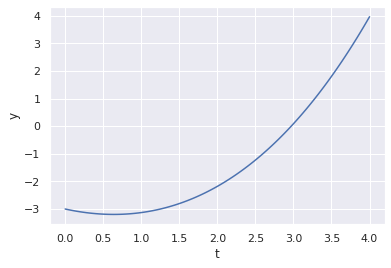

In [128]:
# function dy/dt = t + y/5.
func = lambda y,t : t + y/5.
# Initial condition
y0 = -3  # at t=0
# values at which to compute the solution (needs to start at t=0)
t = np.linspace(0, 4, 101)

y = integrate.odeint(func, y0, t)
# plot the solution, note that y is a column vector
plt.plot(t, y[:,0])
plt.xlabel('t')
plt.ylabel('y')
plt.show()

## torchdiffeq ODE solver on example data

It uses the adjoint method.

In [129]:
y0 = torch.tensor(-3, dtype=torch.float64)
t = torch.linspace(0., 4., 101)

# function dy/dt = t + y/5.
class example(nn.Module):

    def forward(self, t, y):
        return t + y/5

with torch.no_grad():
    y = odeint(example(), y0, t, method='dopri5')

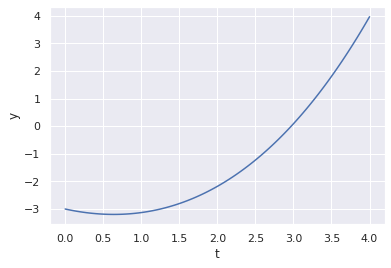

In [130]:
plt.plot(t.numpy(), y.numpy())
plt.xlabel('t')
plt.ylabel('y')
plt.show()

Next, we focus on using the methods defined in torchdiffeq.

## time series data generation
spiral example data

In [131]:
true_y0 = torch.tensor([[2., 0.]])
t = torch.linspace(0., 25., 1000)
true_A = torch.tensor([[-0.1, 2.0], [-2.0, -0.1]])

In [132]:
class Lambda(nn.Module):

    def forward(self, t, y):
        return torch.mm(y**3, true_A)

with torch.no_grad():
    true_y = odeint(Lambda(), true_y0, t, method='dopri5')

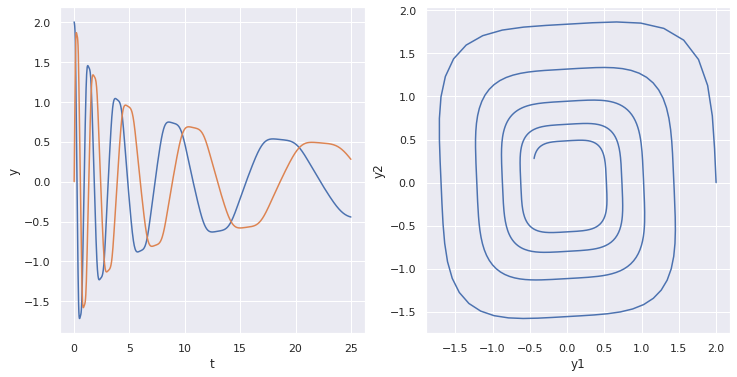

In [133]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,6))

ax1.plot(t.numpy(), true_y.numpy()[:,0,0], t.numpy(), true_y.numpy()[:,0,1])
ax1.set_xlabel('t')
ax1.set_ylabel('y')
ax2.plot(true_y.numpy()[:,0,0], true_y.numpy()[:,0,1])
ax2.set_xlabel('y1')
ax2.set_ylabel('y2')

plt.show()

## Neural ODE model

In [149]:
class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 2),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y**3)

## Training

Check before training (Get the prediction using the correct initial condition)

In [152]:
n_ode = ODEFunc()
pred_y = odeint(n_ode, true_y0, t, method='dopri5') 
loss = torch.mean(torch.abs(pred_y - true_y))

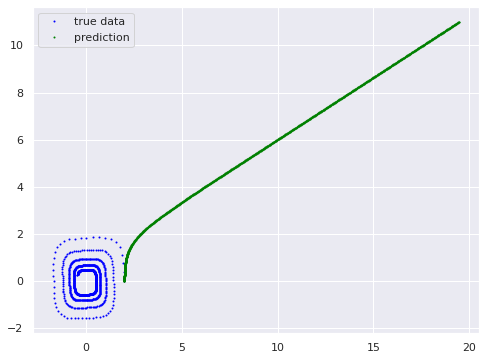

In [153]:
plt.figure(figsize=(8,6))
plt.plot(true_y.numpy()[:,0,0], true_y.numpy()[:,0,1],'.',color = 'blue', markersize=2, label ='true data')
plt.plot(pred_y.detach().numpy()[:,0,0], pred_y.detach().numpy()[:,0,1], '.',color = 'green', markersize=2, label = 'prediction')
plt.legend(loc = "best")

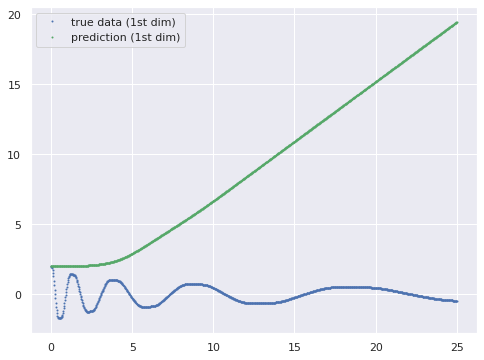

In [154]:
plt.figure(figsize=(8,6))
plt.plot(t,true_y.numpy()[:,0,0], '.', color = 'b', markersize=2, label="true data (1st dim)")
plt.plot(t,pred_y.detach().numpy()[:,0,0], '.', color = 'g', markersize=2, label="prediction (1st dim)")
plt.legend(loc = "best")

In [138]:
print(loss)

tensor(4.4159, grad_fn=<MeanBackward0>)


In [14]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Epoch 0000 | Total Loss 0.708263
Epoch 0020 | Total Loss 0.730147
Epoch 0040 | Total Loss 0.687141
Epoch 0060 | Total Loss 0.625507
Epoch 0080 | Total Loss 0.683083
Epoch 0100 | Total Loss 0.611237
Epoch 0120 | Total Loss 0.735348
Epoch 0140 | Total Loss 1.015944
Epoch 0160 | Total Loss 0.590341
Epoch 0180 | Total Loss 0.622324
Epoch 0200 | Total Loss 0.335513
Epoch 0220 | Total Loss 0.275432
Epoch 0240 | Total Loss 0.508590
Epoch 0260 | Total Loss 0.251544
Epoch 0280 | Total Loss 0.532180
Epoch 0300 | Total Loss 0.296915
Epoch 0320 | Total Loss 0.297516
Epoch 0340 | Total Loss 0.515252
Epoch 0360 | Total Loss 0.229974
Epoch 0380 | Total Loss 0.248328
Epoch 0400 | Total Loss 0.252103


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Epoch 0420 | Total Loss 0.384696


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Epoch 0440 | Total Loss 0.235087


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Epoch 0460 | Total Loss 0.189554


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Epoch 0480 | Total Loss 0.252796


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


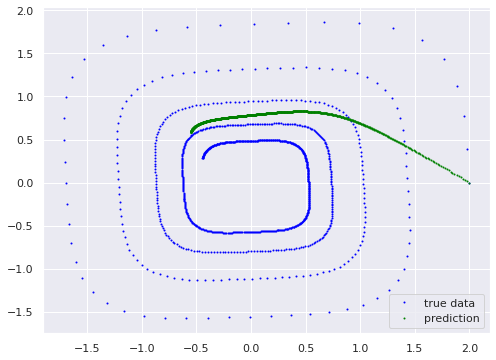

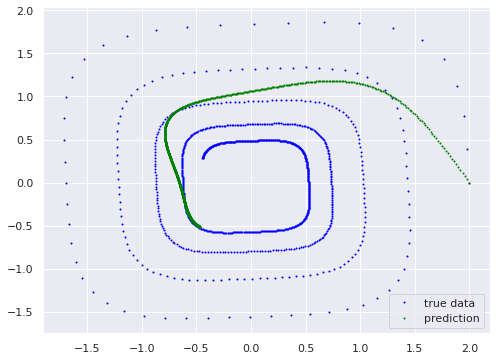

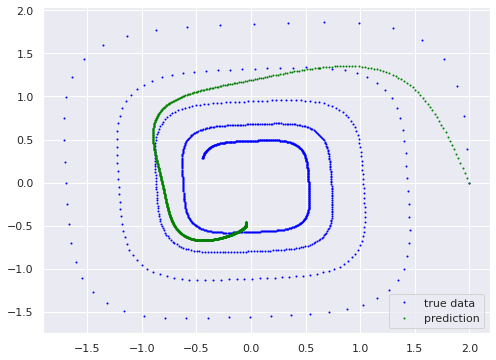

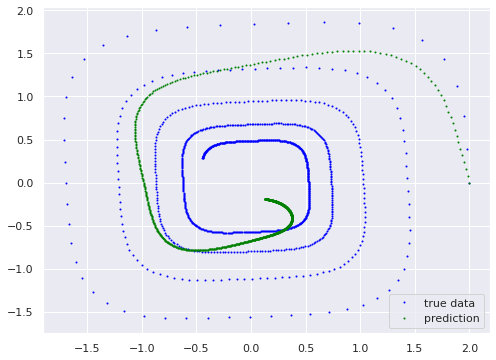

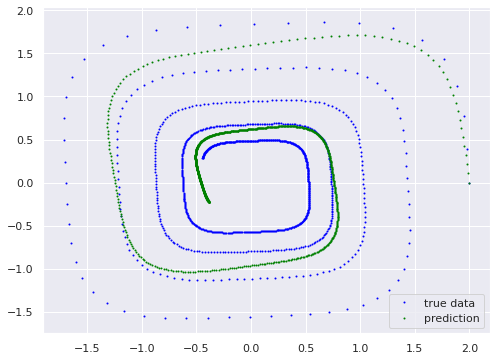

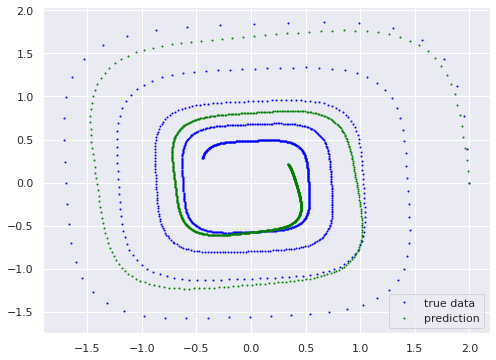

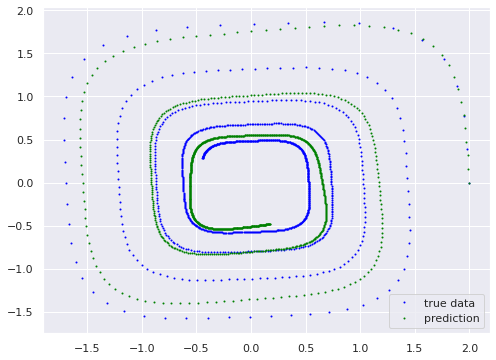

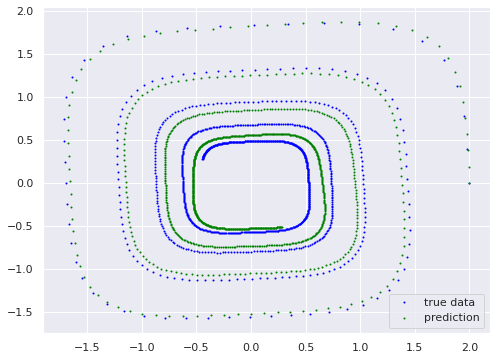

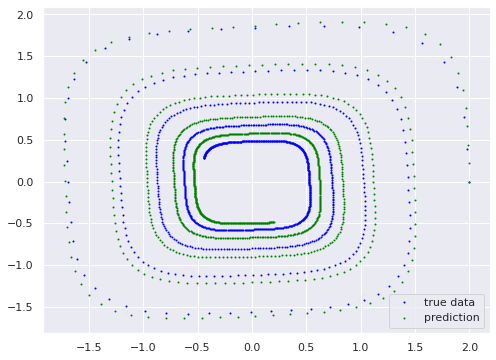

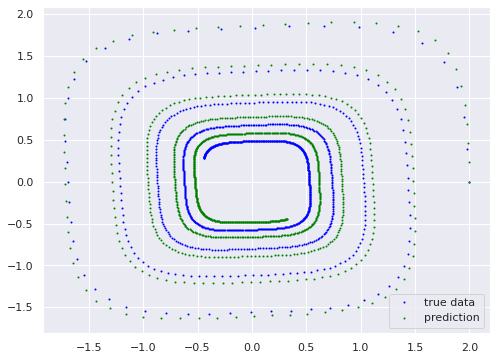

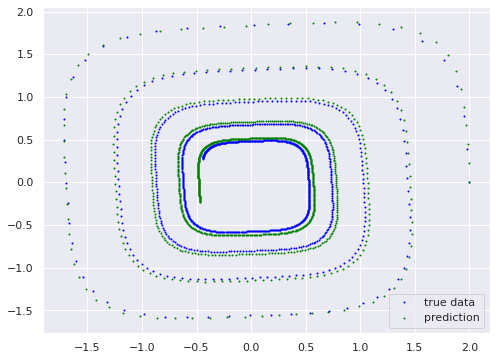

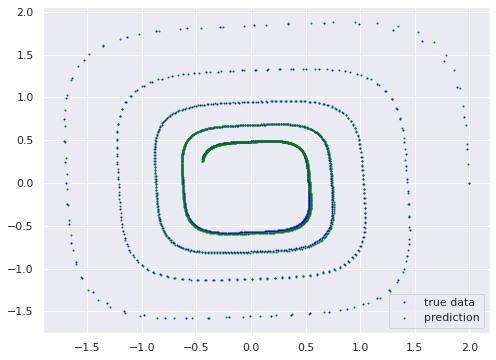

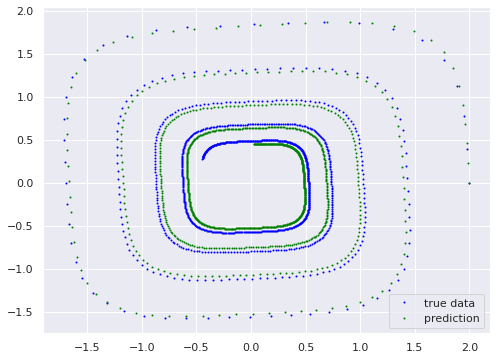

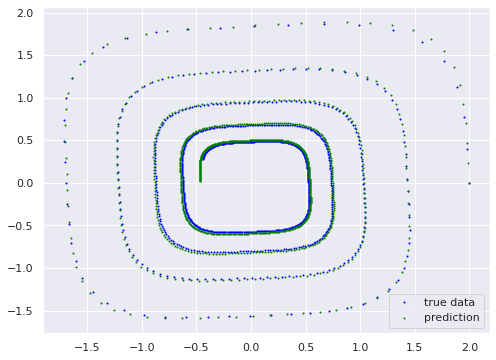

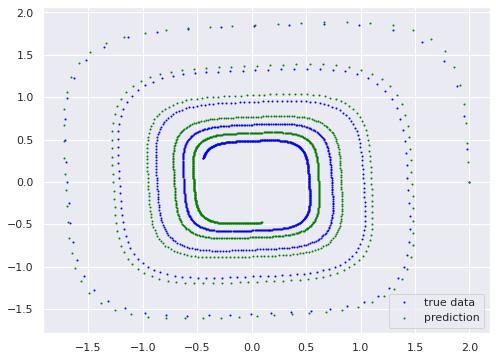

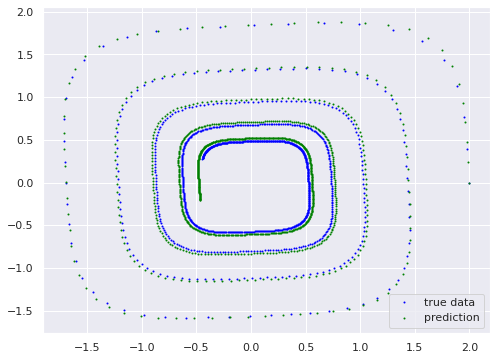

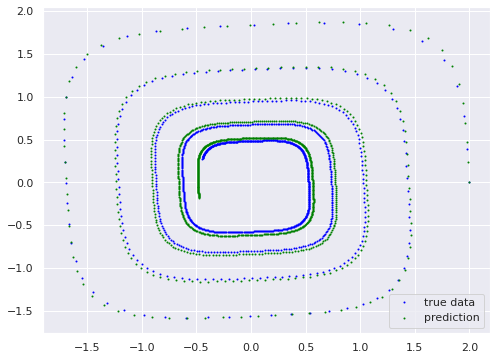

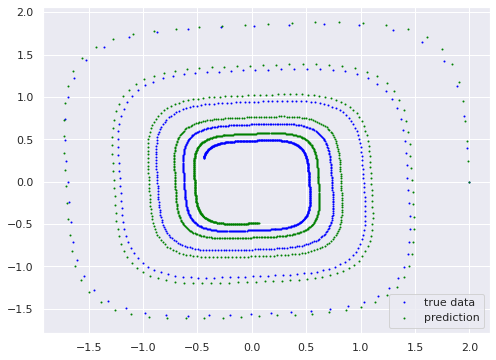

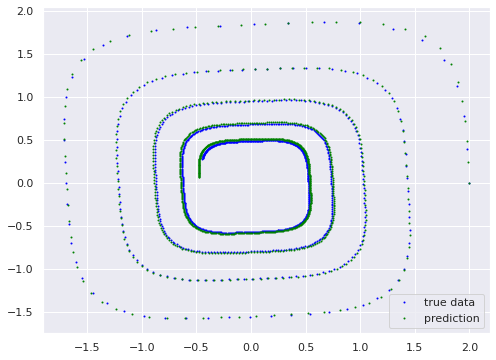

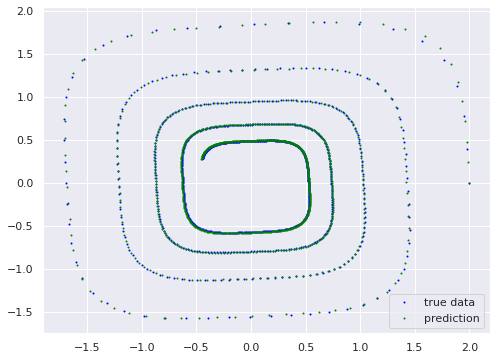

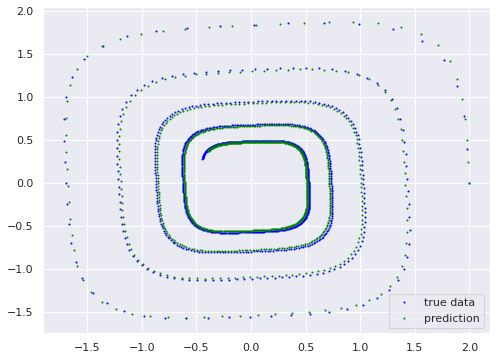

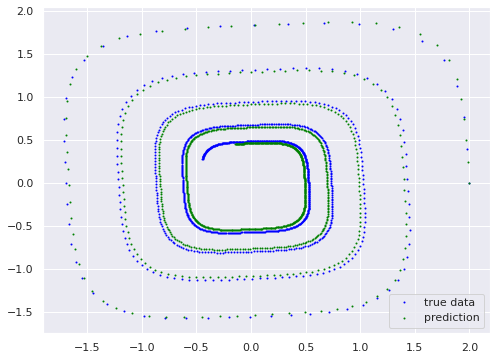

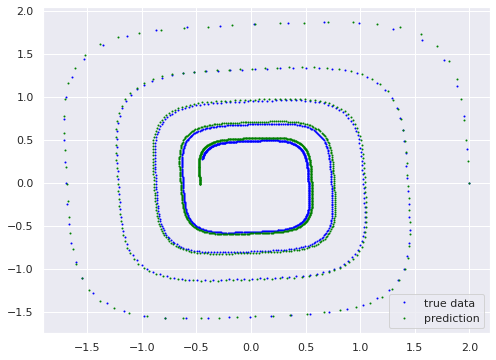

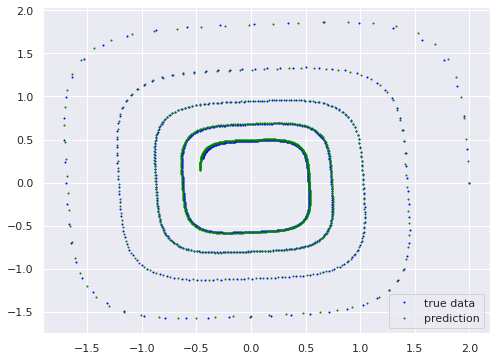

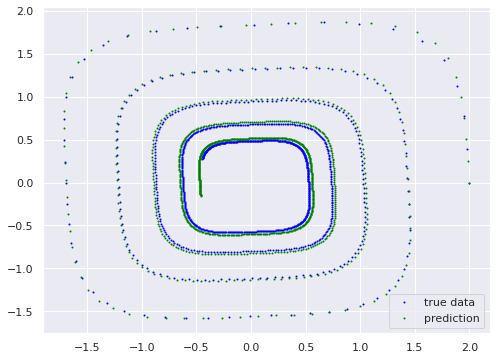

In [181]:
n_ode = ODEFunc()
batch_size = 20
batch_time = 10
learning_rate = 1e-3
EPOCH = 500
optimizer = optim.Adam(n_ode.parameters(), lr=learning_rate)
ii = 0
for epoch in range(EPOCH):

  optimizer.zero_grad()

  s = torch.from_numpy(np.random.choice(np.arange(t.shape[0] - batch_time, dtype=np.int64), batch_size, replace=False)) ## randomly selected IDs for batch
  batch_y0 = true_y[s]  # (M, D)
  batch_t = t[:batch_time]  # (T)
  batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)

  pred_y = odeint(n_ode, batch_y0, batch_t)

  loss = torch.mean(torch.abs(pred_y - batch_y))
  loss.backward()
  optimizer.step()

  
  if epoch % 20 == 0:    
    with torch.no_grad():
      pred_y = odeint(n_ode, true_y0, t)
      loss = torch.mean(torch.abs(pred_y - true_y))
      print('Epoch {:04d} | Total Loss {:.6f}'.format(epoch, loss.item()))
      plt.figure(figsize=(8,6))
      plt.plot(true_y.numpy()[:,0,0], true_y.numpy()[:,0,1],'.',color = 'blue', markersize=2, label ='true data')
      plt.plot(pred_y.detach().numpy()[:,0,0], pred_y.detach().numpy()[:,0,1], '.',color = 'green', markersize=2, label = 'prediction')
      plt.legend(loc = "best")
      plt.savefig('/content/drive/My Drive/{:03d}'.format(ii))
      ii += 1



## Save the evolutionary process as GIF

In [182]:
import imageio

images = []
filenames = []
for ii in range(25):
  filenames.append('{:03d}'.format(ii)+'.png')

import os
os.chdir('/content/drive/My Drive')
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('movie.gif', images)

## time series generation
Another set of more complex underlying dynamical system

In [5]:
t = torch.linspace(0., 25., 1000)
true_y0 = torch.tensor([[-1., 0.]])
class Lambda(nn.Module):
    def __init__(self, A, B, y0):
        super(Lambda, self).__init__()
        self.A = nn.Linear(2, 2, bias=False)
        self.A.weight = nn.Parameter(A)
        self.B = nn.Linear(2, 2, bias=False)
        self.B.weight = nn.Parameter(B)
        self.y0 = nn.Parameter(y0)

    def forward(self, t, y):
        yTy0= torch.sum(y*self.y0, dim = 1)
        dydt = torch.sigmoid(yTy0) * self.A(y - self.y0) + torch.sigmoid(-yTy0) * self.B(y + self.y0)
        return dydt

with torch.no_grad():
    true_y = odeint(Lambda(torch.tensor([[-0.1, -0.5], [0.5, -0.1]]), torch.tensor([[0.2, 1.], [-1, 0.2]]), 
                           torch.tensor([[-1., 0.]])),torch.tensor([[-1., 0.]]), t, method='dopri5')

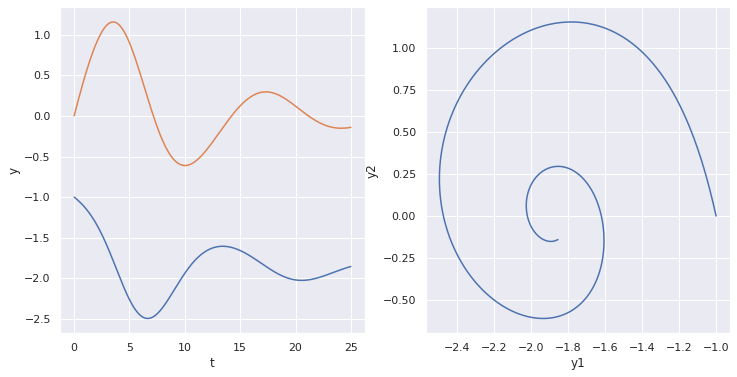

In [6]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,6))

ax1.plot(t.numpy(), true_y.numpy()[:,0,0], t.numpy(), true_y.numpy()[:,0,1])
ax1.set_xlabel('t')
ax1.set_ylabel('y')
ax2.plot(true_y.numpy()[:,0,0], true_y.numpy()[:,0,1])
ax2.set_xlabel('y1')
ax2.set_ylabel('y2')

plt.show()

In [15]:
class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.ReLU(),
            nn.Linear(50, 20),
            nn.Linear(20, 20),
            nn.ReLU(),
            nn.Linear(20, 2),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)

In [16]:
n_ode = ODEFunc()
batch_size = 20
batch_time = 10
learning_rate = 1e-3
EPOCH = 1000
optimizer = optim.Adam(n_ode.parameters(), lr=learning_rate)
ii = 0
for epoch in range(EPOCH):

  optimizer.zero_grad()

  s = torch.from_numpy(np.random.choice(np.arange(t.shape[0] - batch_time, dtype=np.int64), batch_size, replace=False)) ## randomly selected IDs for batch
  batch_y0 = true_y[s]  # (M, D)
  batch_t = t[:batch_time]  # (T)
  batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)

  pred_y = odeint(n_ode, batch_y0, batch_t)

  loss = torch.mean(torch.abs(pred_y - batch_y))
  loss.backward()
  optimizer.step()

  
  if epoch % 20 == 0:    
    with torch.no_grad():
      pred_y = odeint(n_ode, true_y0, t)
      loss = torch.mean(torch.abs(pred_y - true_y))
      print('Epoch {:04d} | Total Loss {:.6f}'.format(epoch, loss.item()))

      f, (ax1, ax2) = plt.subplots(1, 2, figsize = (16,6))
      ax1.plot(t.numpy(), true_y.numpy()[:,0,0], t.numpy(), true_y.numpy()[:,0,1], '.', markersize=2)
      ax1.plot(t.numpy(), pred_y.detach().numpy()[:,0,0], t.numpy(), pred_y.detach().numpy()[:,0,1], '.', markersize=2)
      ax1.set_xlabel('t')
      ax1.set_ylabel('y')
      ax1.set_title('trajectories')
      ax2.plot(true_y.numpy()[:,0,0], true_y.numpy()[:,0,1],'.',color = 'blue', markersize=2, label ='true data')
      ax2.plot(pred_y.detach().numpy()[:,0,0], pred_y.detach().numpy()[:,0,1], '.',color = 'green', markersize=2, label = 'prediction')
      ax2.set_xlabel('y1')
      ax2.set_ylabel('y2')
      ax2.set_title('phase portrait')
      plt.legend(loc = "best")


      plt.savefig('/content/drive/My Drive/{:03d}'.format(ii))
      ii += 1



Output hidden; open in https://colab.research.google.com to view.

In [17]:
import imageio

images = []
filenames = []
for ii in range(35):
  filenames.append('{:03d}'.format(ii)+'.png')

import os
os.chdir('/content/drive/My Drive')
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('movie.gif', images)